In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# df_results = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\ufc_da2_model_results_test.csv')
df_history = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\model_results_train_v2.csv')
df_results = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\model_results_v2.csv')

df_results['pred_winner'] = np.where(df_results['correct_pred']==1, df_results['winner'], np.abs(1-df_results['winner']))
df_results['Date'] = df_results["event_dates"].copy()
df_results.sort_values(by='Date', ascending=True).reset_index(drop=True)

df_results['prob_winner'] = df_results[['red_probs','blue_probs']].max(axis=1)
df_results['winner_odds'] = np.where(df_results['winner'] == 1, df_results['open_red'], df_results['open_blue'])
df_results['choice_fighter_bet'] = np.where(df_results['pred_winner'] == 1, df_results['open_red'], df_results['open_blue'])
df_results['Date'] = df_results["Date"].astype(str)

df_correct_pred = df_results[df_results["correct_pred"] == 1].copy() 
df_incorrect_pred = df_results[df_results["correct_pred"] == 0].copy()

pred_correct_odds = df_results[df_results["correct_pred"] == 1]['choice_fighter_bet'].value_counts().sort_index()
pred_incorrect_odds = df_results[df_results["correct_pred"] == 0]['choice_fighter_bet'].value_counts().sort_index()

df_results.head()

,Unnamed: 0,blue_probs,red_probs,pred_winner,winner,correct_pred,event_dates,open_red,open_blue,close1_red,close1_blue,close2_red,close2_blue,red_fighter,blue_fighter,Date,prob_winner,winner_odds,choice_fighter_bet
0,0,0.543981,0.456019,0,0,1,2023-08-12,163.0,-200.0,164.0,-225.0,180.0,-198.0,josh parisian,martin buday,2023-08-12,0.543981,-200.0,-200.0
1,1,0.570416,0.429584,0,0,1,2023-08-12,300.0,-400.0,260.0,-450.0,350.0,-335.0,jp buys,marcus mcghee,2023-08-12,0.570416,-400.0,-400.0
2,2,0.788572,0.211428,0,0,1,2023-08-12,163.0,-200.0,158.0,-200.0,170.0,-188.0,polyana viana,iasmin lucindo,2023-08-12,0.788572,-200.0,-200.0
3,3,0.443205,0.556795,1,1,1,2023-08-12,-225.0,175.0,-200.0,140.0,-170.0,170.0,khalil rountree jr,chris daukaus,2023-08-12,0.556795,-225.0,-225.0
4,4,0.727696,0.272304,0,1,0,2023-08-12,200.0,-250.0,175.0,-320.0,250.0,-225.0,cub swanson,hakeem dawodu,2023-08-12,0.727696,200.0,-250.0


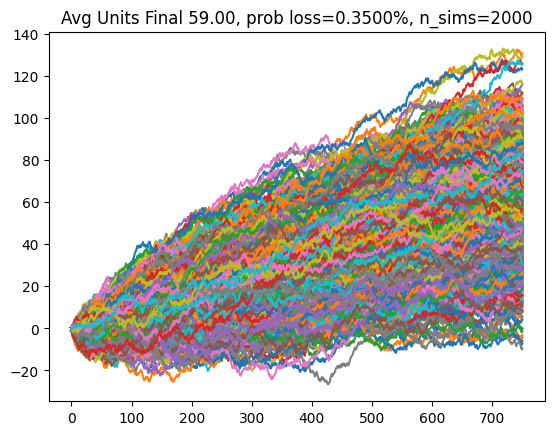

In [ ]:
def american_to_decimal(odds):
    return np.where(odds > 0, odds / 100 + 1, 100 / np.abs(odds) + 1)

def monte_carlo_units(df, red_prob_c, blue_prob_c, red_odds_c, blue_odds_c, n_sims): 
    df['red_dec'] = american_to_decimal(df[red_odds_c])
    df['blue_dec'] = american_to_decimal(df[blue_odds_c])
    sim_units = []
    for _ in range(n_sims):
        round_units = []
        for i, row in df.iterrows():
            red_prob = row[red_prob_c]
            blue_prob = row[blue_prob_c]
            winner = 'red' if red_prob > blue_prob else 'blue'
            winning_probs = red_prob if winner == 'red' else blue_prob
            winner_dec = row['red_dec']-1 if winner == 'red' else row['blue_dec']-1
            random_sample = np.random.rand()
            if random_sample <= winning_probs:
                round_units.append(winner_dec)
            else:
                round_units.append(-1)
        sim_units.append(round_units)

    for units in sim_units:
        plt.plot(np.cumsum(units))
    
    final_results = [np.cumsum(units)[-1] for units in sim_units]  # last cumsum per simulation
    avg_final = np.mean(final_results)
    prob_loss = (np.sum(np.array(final_results) < 0) / n_sims) * 100
    plt.title(f'Avg Units Final {avg_final:.2f}, prob loss={prob_loss:.4f}%, n_sims={n_sims}')
    plt.show()

monte_carlo_units(df_results,'red_probs', 'blue_probs', 'open_red', 'open_blue', 2000)

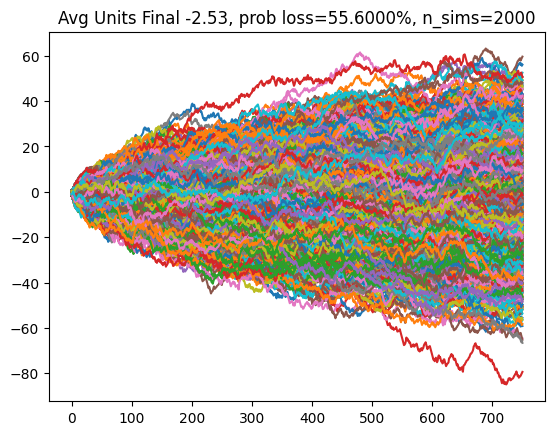

In [24]:
monte_carlo_units(df_results,'red_probs', 'blue_probs', 'close1_red', 'close1_blue', 2000)

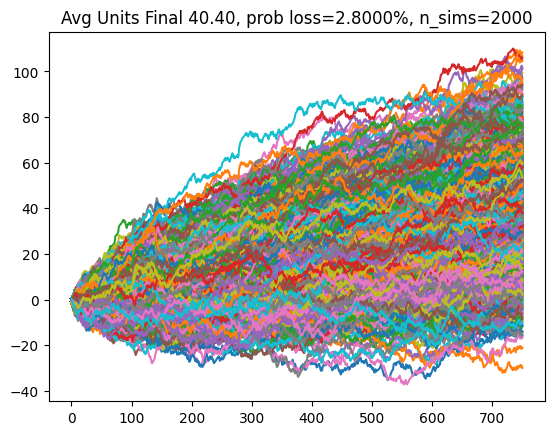

In [25]:
monte_carlo_units(df_results,'red_probs', 'blue_probs', 'close2_red', 'close2_blue', 2000)

In [ ]:
def kelly_stake_fraction(p, fair_decimal):
    """Return Kelly fraction given probability and fair decimal odds."""
    b = fair_decimal - 1
    return (p * (b + 1) - 1) / b if b > 0 else 0

def simulate_kelly_monte_carlo(
    df,
    prob_cols,
    fair_decimal_cols,
    real_decimal_cols,
    pred_winner_col,
    date_col='date',
    winner_col='winner',
    init_bankroll=1000,
    bankroll_floor=None,
    n_simulations=100
):
    df = df.sort_values(by=date_col)
    unique_dates = sorted(df[date_col].unique())
    bankroll_trajectories = []

    for sim in range(n_simulations):
        bankroll = init_bankroll
        bankroll_history = [bankroll]

        for date, group in df.groupby(date_col, sort=True):
            group_profit = 0

            for _, row in group.iterrows():
                bet_idx = int(row[pred_winner_col])

                # Kelly fraction
                p = row[prob_cols[bet_idx]]
                fair_odds = row[fair_decimal_cols[bet_idx]]
                stake_frac = kelly_stake_fraction(p, fair_odds)

                if stake_frac <= 0:
                    continue

                stake = bankroll * stake_frac * 0.25
                real_odds = row[real_decimal_cols[bet_idx]]

                # Monte Carlo: draw outcome
                probs = np.array([row[col] for col in prob_cols])
                probs = probs / probs.sum()  # normalize to sum exactly 1
                winner_sim = np.random.choice(len(probs), p=probs)

                if winner_sim == int(row[winner_col]):
                    profit = stake * (real_odds - 1)
                else:
                    profit = -stake

                group_profit += profit

            # Update bankroll after group
            bankroll += group_profit
            if bankroll_floor is not None and bankroll < bankroll_floor:
                bankroll += bankroll_floor
            bankroll_history.append(bankroll)

        bankroll_trajectories.append(bankroll_history)

    bankroll_trajectories = np.array(bankroll_trajectories)
    final_bankrolls = bankroll_trajectories[:, -1]

    # Metrics
    mean_final = np.mean(final_bankrolls)
    std_final = np.std(final_bankrolls)
    ruin_prob = np.mean(final_bankrolls < init_bankroll)

    # Plot
    plt.figure(figsize=(12, 6))
    x_positions = range(len(unique_dates) + 1)
    for traj in bankroll_trajectories:
        plt.plot(x_positions, traj, alpha=0.3)

    label_every = 5
    plt.xticks(
        x_positions[::label_every],
        [d for i, d in enumerate(unique_dates) if i % label_every == 0],
        rotation=45, ha="right"
    )

    plt.axhline(init_bankroll, color="gray", linestyle="--", label="Initial Bankroll")
    plt.xlabel("Date")
    plt.ylabel("Bankroll")
    plt.title(
        f"Monte Carlo Kelly Simulation\n"
        f"Mean Final: {mean_final:.2f}, Std: {std_final:.2f}, Loss Prob: {ruin_prob:.2%}"
    )
    plt.tight_layout()
    plt.show()

    return bankroll_trajectories, final_bankrolls

In [ ]:
prob_cols = ['blue_probs', 'red_probs']
fair_decimal_odds = ['dec_fair_open_blue', 'dec_fair_open_red']  # your decimal odds columns
real_decimal_odds = ['dec_open_blue', 'dec_open_red']
bankroll_history, payout_history = simulate_kelly_monte_carlo(
    df_results,
    prob_cols=prob_cols,
    fair_decimal_cols=fair_decimal_odds,
    real_decimal_cols=real_decimal_odds,
    pred_winner_col='pred_winner',
    date_col='Date',
    init_bankroll=1000,
    bankroll_floor=100,
    n_simulations=500
)